# End-to-End Spleen Segmentation from DICOM to DICOM-SEG with AI

# 🧠 AI-Powered Spleen Segmentation Pipeline: DICOM ➝ NIfTI ➝ DICOM-SEG

This pipeline automates the process of converting CT scan DICOM series to segmentation-ready NIfTI files, performs spleen segmentation using a trained MONAI UNet model, and converts the output into DICOM-SEG format using `dcmqi`.

---

## ✅ Step-by-Step Workflow

### 📂 Step 1: Convert DICOM to NIfTI
- Input Folder: `/content/drive/MyDrive/SpleenNifti/Spleen AI Traning/`
- Output Folder: `/content/out/nifti/`
- For each patient subfolder, convert the DICOM series to a single `.nii.gz` file using `SimpleITK`.

---

### 🧠 Step 2: Run Segmentation using MONAI
- Model: Trained 3D UNet (`best_metric_model.pth`)
- Input: NIfTI images from `/content/out/nifti/`
- Output: Segmentation masks saved to `/content/out/segNifti/<PatientID>/<PatientID>_seg.nii.gz`
- Uses MONAI transforms, sliding window inference, and argmax for class prediction.

---

### 💾 Step 3: Convert Segmentation NIfTI to DICOM-SEG
- Tool: [`itkimage2segimage` from DCMQI](https://github.com/QIICR/dcmqi)
- Inputs:
  - `--inputImageList`: predicted NIfTI mask
  - `--inputDICOMDirectory`: original DICOM folder
  - `--inputMetadata`: JSON defining segment labels and display properties
- Output:
  - DICOM-SEG file saved to `/content/out/dicomSeg/<PatientID>_seg.dcm`

---



In [ ]:
# 🚀 Install compatible versions
%pip install numpy==1.23.5
%pip install monai==1.2.0
%pip install SimpleITK==2.2.1
%pip install nibabel==5.1.0
%pip install pydicom==2.4.4
%pip install highdicom==0.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have nump

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import SimpleITK as sitk
import torch
import numpy as np
import json
import subprocess
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, Invertd, AsDiscreted, SaveImaged
)
from monai.data import Dataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
import matplotlib.pyplot as plt
import subprocess

In [ ]:
# 🛠️ Paths
dicom_root = "/content/drive/MyDrive/SpleenNifti/Spleen AI Traning"
output_root = "/content/out/"
model_path = "/content/drive/MyDrive/SpleenNifti/ImprovedResults/best_metric_model.pth"
dcmqi_bin = "/content/drive/MyDrive/dcmqi-1.4.0-linux/dcmqi-1.4.0-linux/bin/itkimage2segimage"
output_dicomseg_root = "/content/out/dicomSeg"
metadata_json_path = os.path.join(output_root, "segment_attributes.json")
nifti_output_dir = os.path.join(output_root, "nifti")
segmentation_nifti_dir = "/content/out/segNifti"
# Create all the important dirs
os.makedirs(segmentation_nifti_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(output_root, exist_ok=True)
os.makedirs(output_dicomseg_root, exist_ok=True)

## 🧾 Metadata for DICOM-SEG Generation (`segment_attributes.json`)

To generate a valid DICOM-SEG file using `dcmqi`'s `itkimage2segimage` tool, a **segment metadata JSON file** is required. This file defines the label information, algorithm details, and the clinical meaning of the segmented structure.

Below is the metadata configuration used for **automatic spleen segmentation**:


In [ ]:
# 📦 Metadata for itkimage2segimage
segment_metadata = {
  "@schema": "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/seg-schema.json#",
  "segmentAttributes": [[{
    "labelID": 1,
    "SegmentDescription": "Spleen",
    "SegmentAlgorithmType": "AUTOMATIC",
    "SegmentAlgorithmName": "UNet3D",
    "SegmentedPropertyCategoryCodeSequence": {
      "CodeValue": "T-D0050", "CodingSchemeDesignator": "SRT", "CodeMeaning": "Tissue"
    },
    "SegmentedPropertyTypeCodeSequence": {
      "CodeValue": "T-62000", "CodingSchemeDesignator": "SRT", "CodeMeaning": "Spleen"
    },
    "recommendedDisplayRGBValue": [255, 0, 0]
  }]]
}
with open(metadata_json_path, "w") as f:
    json.dump(segment_metadata, f, indent=2)

# Check best model output with the input image and label

This loads the trained U-Net model with the best performance checkpoint, applies it to a few validation samples using sliding window inference, and displays a side-by-side comparison of the input image, ground truth label, and model's segmentation output for a specific slice.

In [ ]:
# Step 1: Convert DICOM series to NIfTI
def convert_dicom_series_to_nifti(series_path, output_path):
    try:
        reader = sitk.ImageSeriesReader()
        dicom_series = reader.GetGDCMSeriesFileNames(series_path)
        if not dicom_series:
            print(f"⚠️ No DICOM series found in {series_path}")
            return None, None
        reader.SetFileNames(dicom_series)
        image = reader.Execute()
        sitk.WriteImage(image, output_path)
        print(f"✅ Image saved: {output_path}")
        return output_path, dicom_series
    except Exception as e:
        print(f"❌ Error converting image at {series_path}: {e}")
        return None, None

In [ ]:
# 🔁 Loop through all patient folders
patient_folders = [f for f in os.listdir(dicom_root) if os.path.isdir(os.path.join(dicom_root, f))]
for patient_id in patient_folders:
    print(f"\n🔄 Processing: {patient_id}")
    dicom_folder_path = os.path.join(dicom_root, patient_id)
    nifti_output_path = os.path.join(nifti_output_dir, f"{patient_id}.nii.gz")
    convert_dicom_series_to_nifti(dicom_folder_path, nifti_output_path)


🔄 Processing: CRLM-CT-1002
✅ Image saved: /content/out/nifti/CRLM-CT-1002.nii.gz

🔄 Processing: CRLM-CT-1006
✅ Image saved: /content/out/nifti/CRLM-CT-1006.nii.gz

🔄 Processing: CRLM-CT-1004
✅ Image saved: /content/out/nifti/CRLM-CT-1004.nii.gz

🔄 Processing: CRLM-CT-1005
✅ Image saved: /content/out/nifti/CRLM-CT-1005.nii.gz

🔄 Processing: CRLM-CT-1003
✅ Image saved: /content/out/nifti/CRLM-CT-1003.nii.gz


## 🧠 Model Initialization: MONAI 3D UNet with Dice Loss and Adam Optimizer

This section initializes a 3D UNet model using MONAI for medical image segmentation tasks, specifically tailored for spleen segmentation. The model is trained using Dice Loss and optimized with the Adam optimizer.

---

### 🔧 Model Configuration

```python
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,                  # 3D medical imaging
    in_channels=1,                   # Single channel input (CT scans)
    out_channels=2,                  # Binary segmentation (background vs spleen)
    channels=(16, 32, 64, 128, 256), # Feature maps at each level
    strides=(2, 2, 2, 2),            # Downsampling steps
    num_res_units=2,                 # Number of residual units per level
    norm=Norm.BATCH                 # Batch normalization
).to(device)


In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
model_path =  "/content/drive/MyDrive/SpleenNifti/ImprovedResults/best_metric_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [ ]:
nifti_dir = "/content/out/nifti"
test_data = []

for file in os.listdir(nifti_dir):
    if file.endswith(".nii.gz"):
        test_data.append({
            "image": os.path.join(nifti_dir, file)
        })

print(f"✅ Prepared test_data with {len(test_data)} NIfTI files")


✅ Prepared test_data with 5 NIfTI files


## 🔍 Explanation of Preprocessing and Postprocessing Steps

### 🧪 Test-Time Preprocessing (`test_org_transforms`)

The following preprocessing steps are applied to each input NIfTI image before passing it into the segmentation model:

1. **LoadImaged**: Loads the image from a NIfTI file path into memory.
2. **EnsureChannelFirstd**: Ensures the tensor format is channel-first `[C, D, H, W]`, which is expected by MONAI models.
3. **Orientationd**: Reorients the image to the RAS (Right-Anterior-Superior) coordinate convention for consistency.
4. **Spacingd**: Resamples the image to have uniform voxel spacing `(1.5, 1.5, 2.0)` using bilinear interpolation, standardizing spatial resolution.
5. **ScaleIntensityRanged**: Normalizes voxel intensity values from the range `[-57, 164]` to `[0.0, 1.0]`, improving model stability.
6. **CropForegroundd**: Crops the volume to only include foreground (non-zero) regions, reducing unnecessary background and computation.

---

### 📦 Dataset and DataLoader

- `Dataset`: Applies the above `test_org_transforms` to every item in the `test_data` list of NIfTI files.
- `DataLoader`: Efficiently loads each image batch (with `batch_size=1`) for inference, using 4 workers in parallel.

---

### 🛠️ Post-Processing (`post_transforms`)

After prediction by the model, the following transformations are applied:

1. **Invertd**: Reverses the original preprocessing (spacing, orientation, cropping) to restore the segmentation output to the original image space.
2. **AsDiscreted**: Converts the predicted probability map into a hard label map by selecting the class with the highest probability (argmax).
3. **SaveImaged**: Saves the final predicted segmentation as a NIfTI file with `_seg` suffix in the specified output directory (`segNifti/`), preserving spatial metadata.

---


In [ ]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True),
    SaveImaged(
        keys="pred",
        meta_keys="pred_meta_dict",
        output_dir=segmentation_nifti_dir,
        output_postfix="seg",
        resample=False
    ),
])


In [ ]:
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

2025-04-25 07:30:33,619 INFO image_writer.py:197 - writing: /content/out/segNifti/CRLM-CT-1004/CRLM-CT-1004_seg.nii.gz
2025-04-25 07:30:34,587 INFO image_writer.py:197 - writing: /content/out/segNifti/CRLM-CT-1006/CRLM-CT-1006_seg.nii.gz
2025-04-25 07:30:35,813 INFO image_writer.py:197 - writing: /content/out/segNifti/CRLM-CT-1002/CRLM-CT-1002_seg.nii.gz
2025-04-25 07:30:37,526 INFO image_writer.py:197 - writing: /content/out/segNifti/CRLM-CT-1005/CRLM-CT-1005_seg.nii.gz
2025-04-25 07:30:38,710 INFO image_writer.py:197 - writing: /content/out/segNifti/CRLM-CT-1003/CRLM-CT-1003_seg.nii.gz


## 🖼️ Visualizing Spleen Segmentation Over CT Slices

This script loads a NIfTI CT scan and its corresponding segmentation mask, and visualizes slices where the segmentation is present by overlaying the mask on the original scan.

In [ ]:
import nibabel as nib

# 🧠 Load NIfTI files (replace with your actual paths)
image_path = '/content/out/nifti/CRLM-CT-1003.nii.gz'  # Original CT/MRI image
seg_path = '/content/out/segNifti/CRLM-CT-1003/CRLM-CT-1003_seg.nii.gz'  # Corresponding segmentation mask


Image shape: (512, 512, 51)
Seg shape: (512, 512, 51)


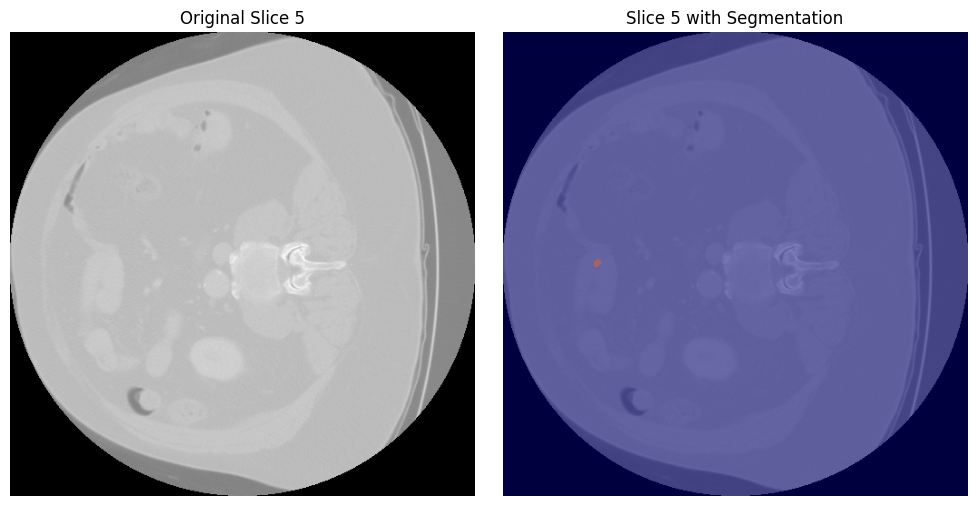

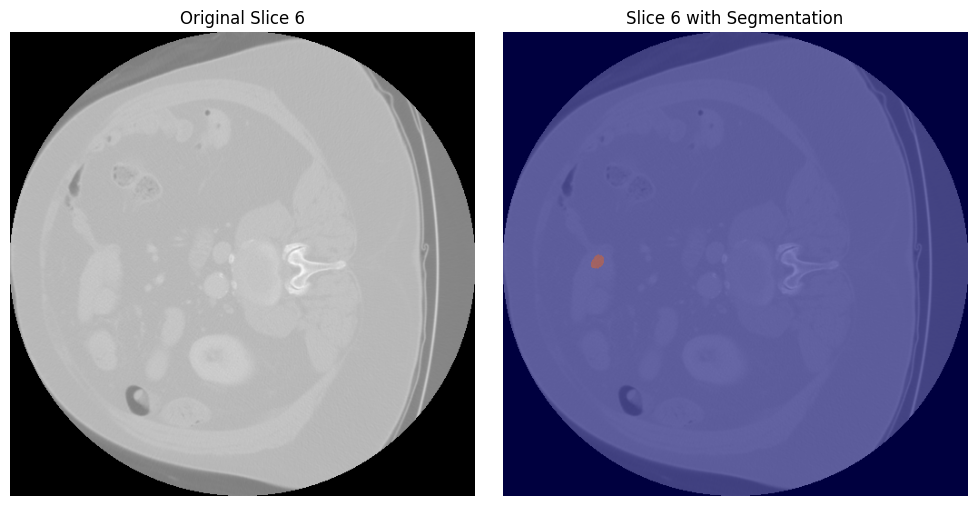

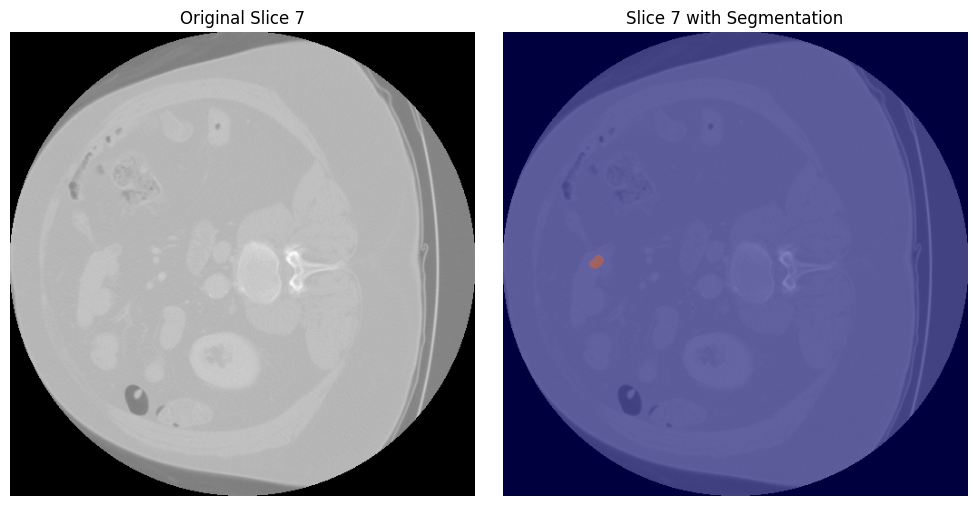

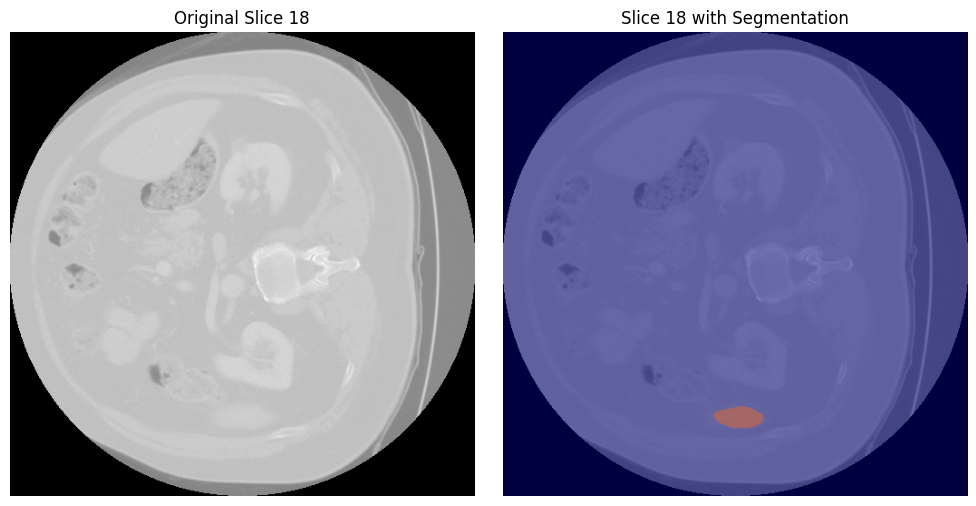

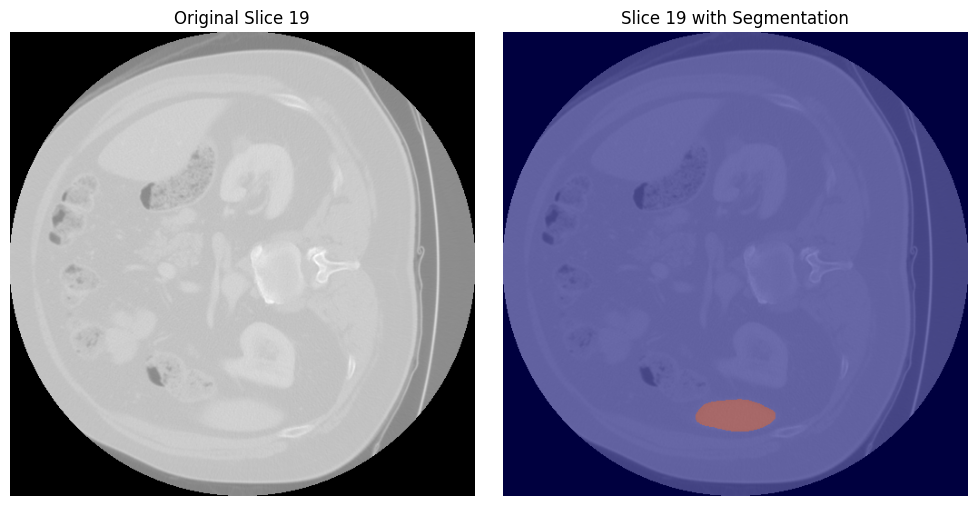

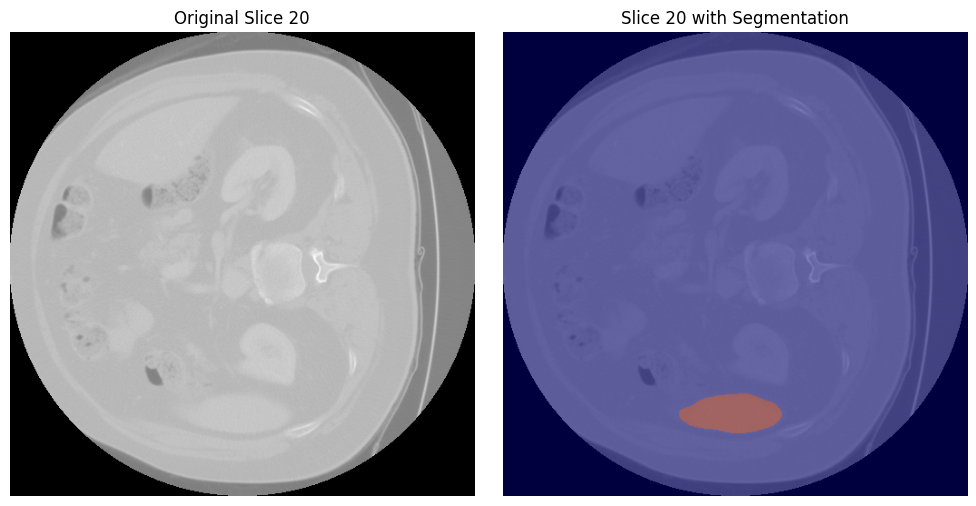

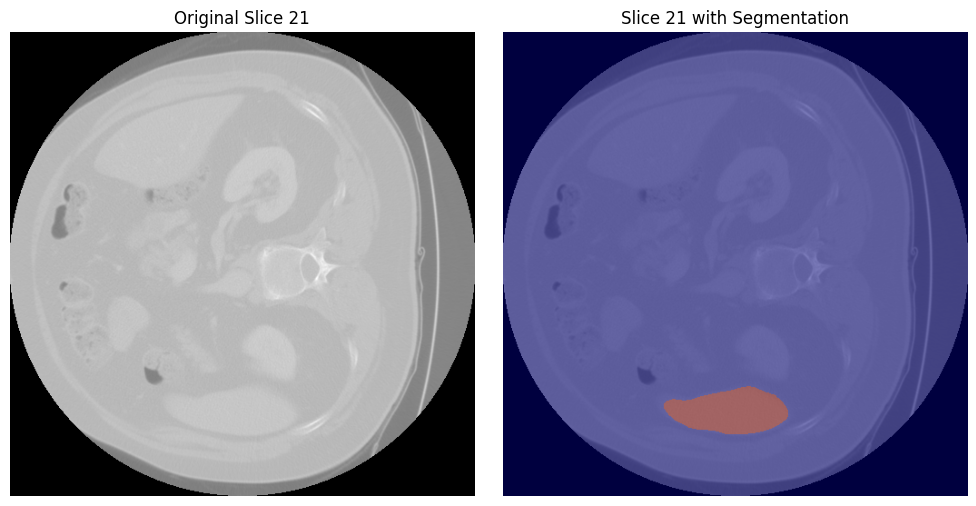

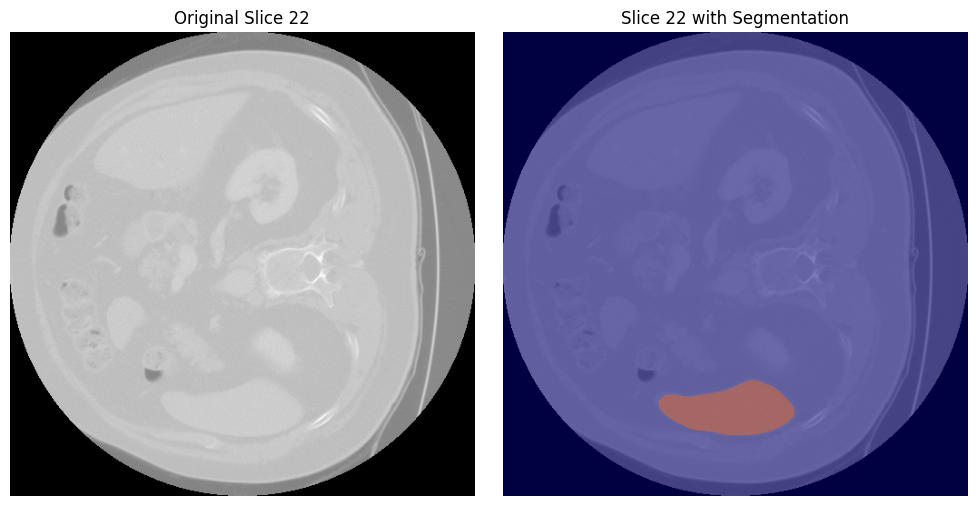

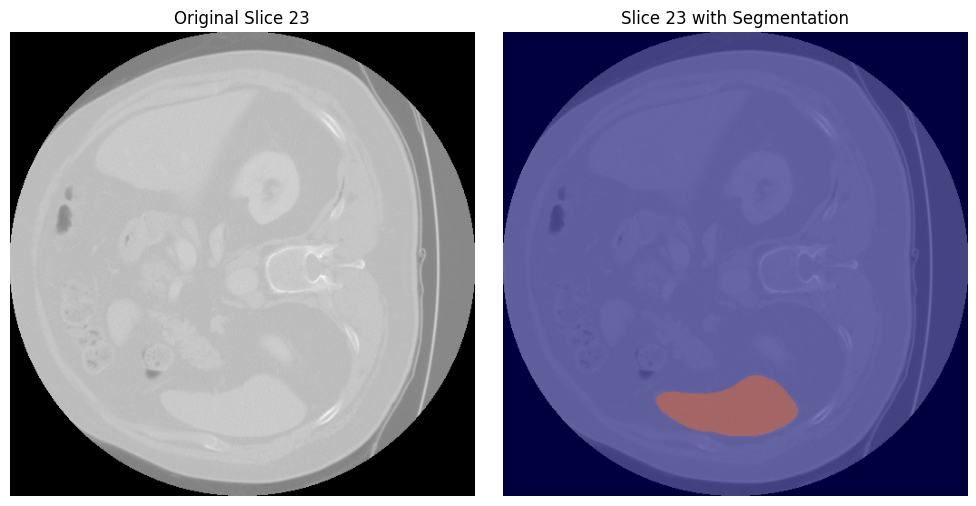

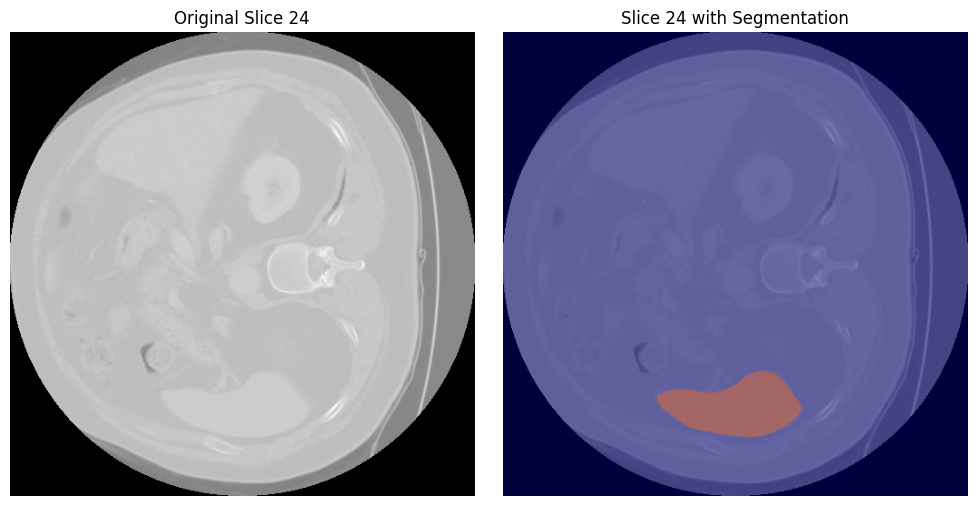

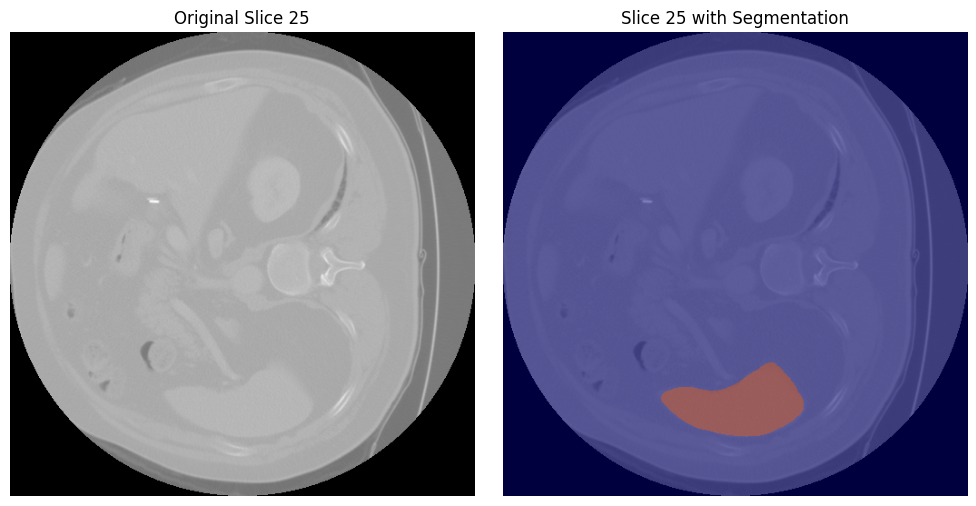

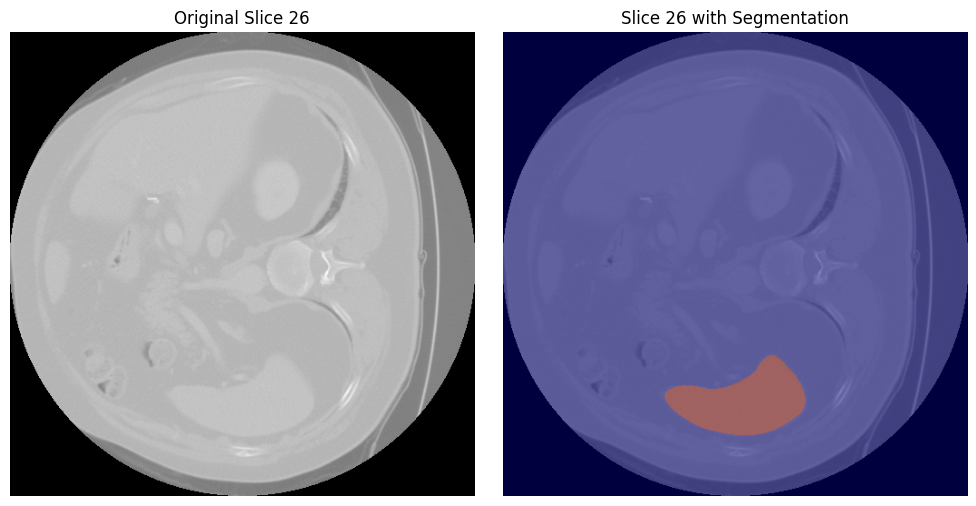

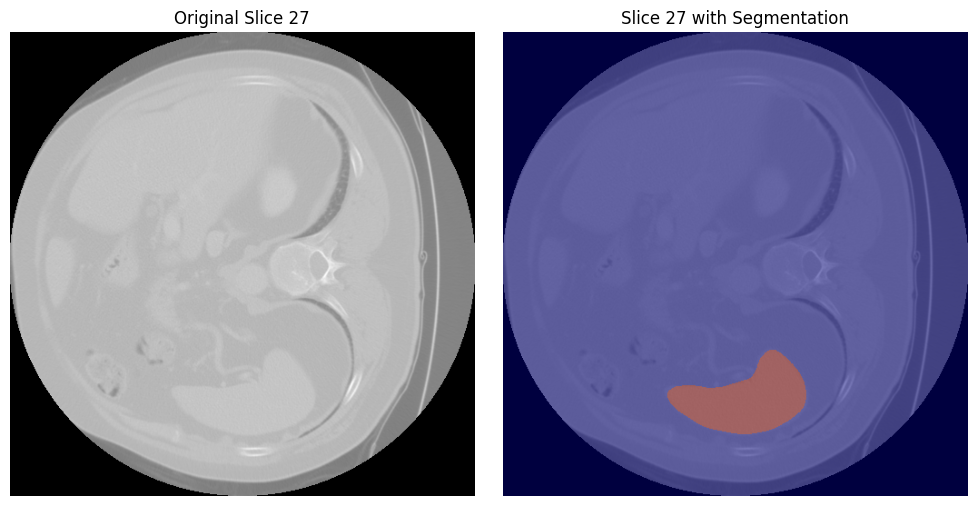

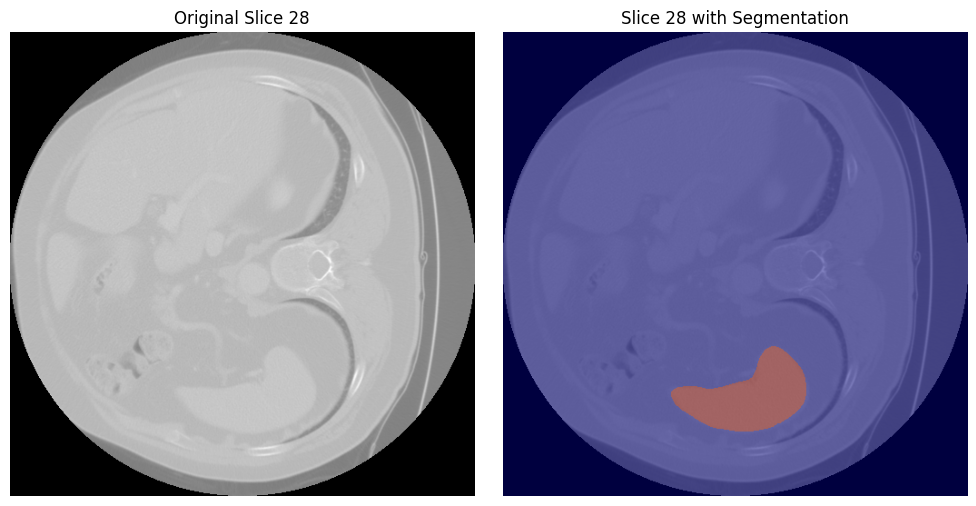

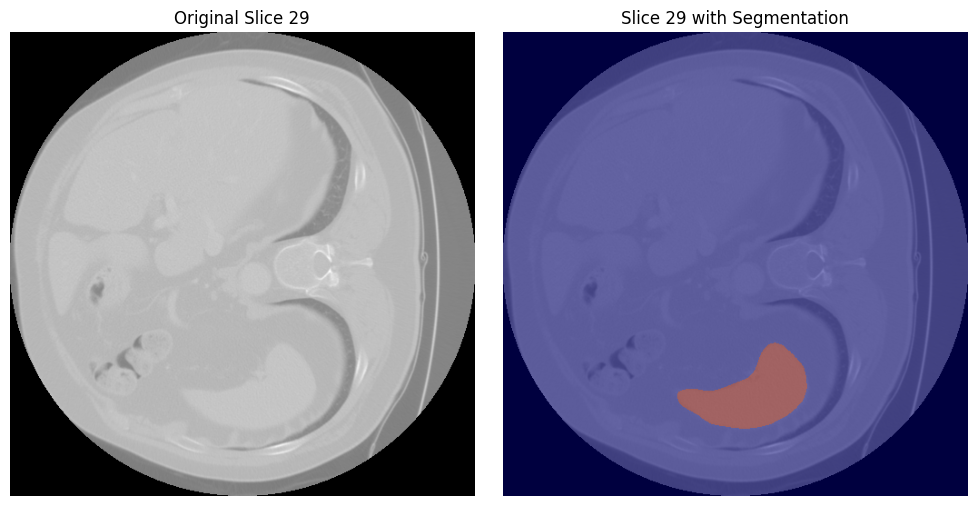

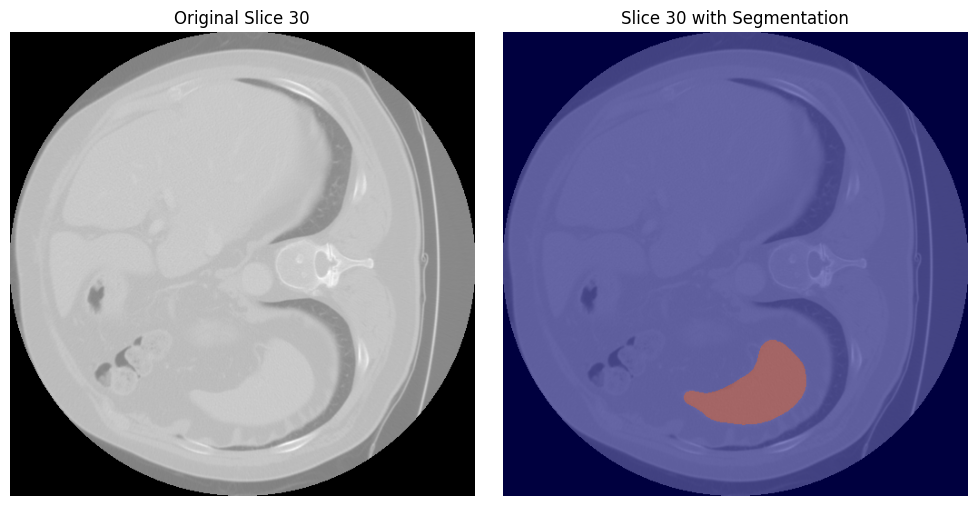

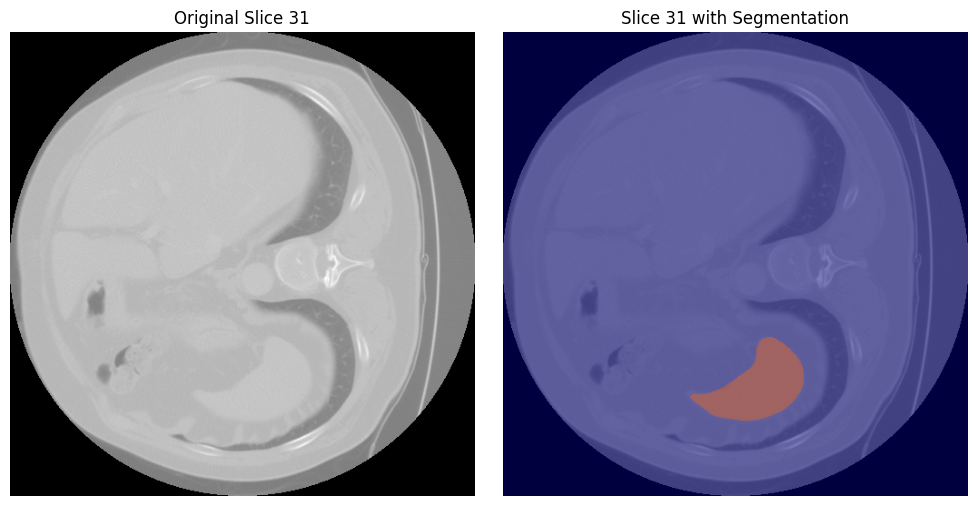

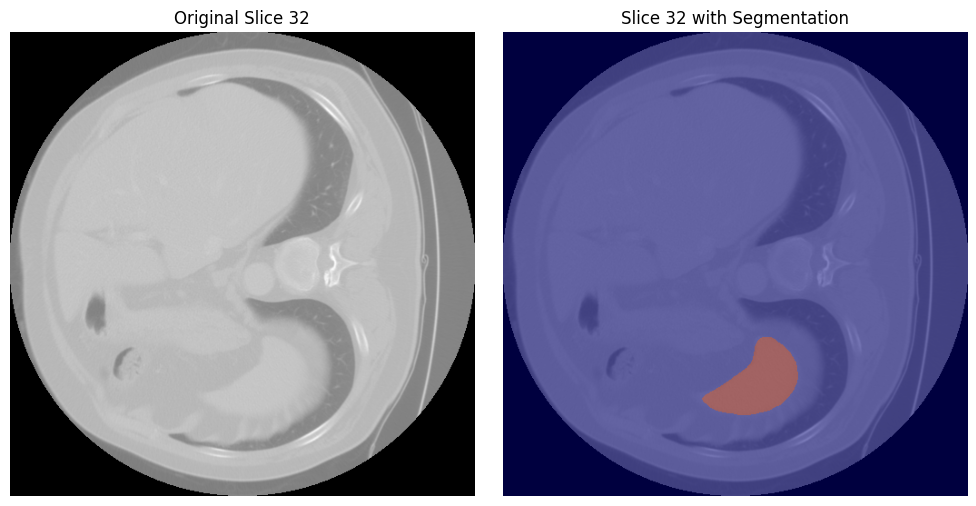

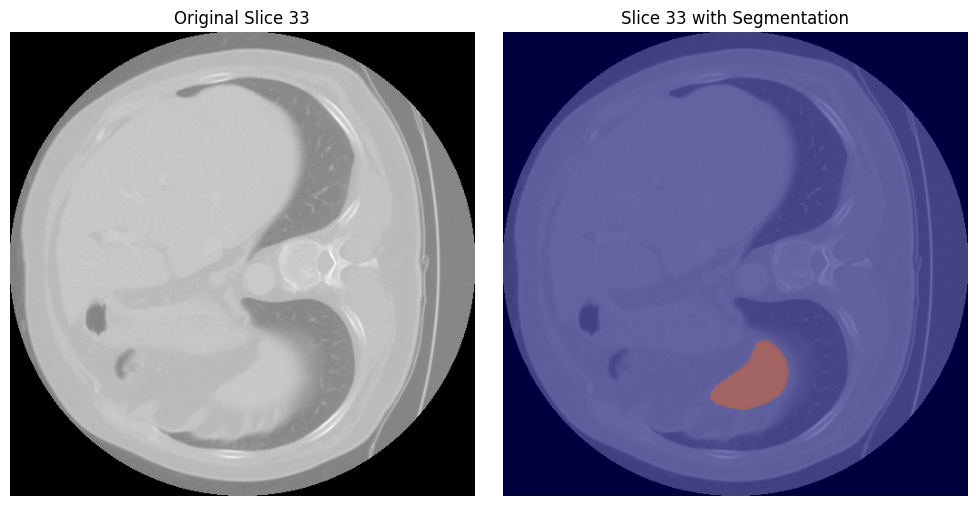

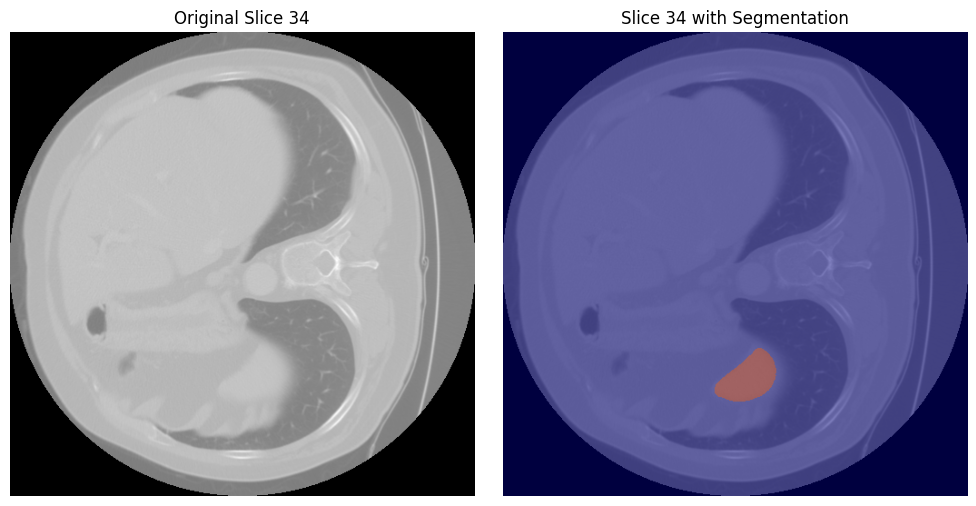

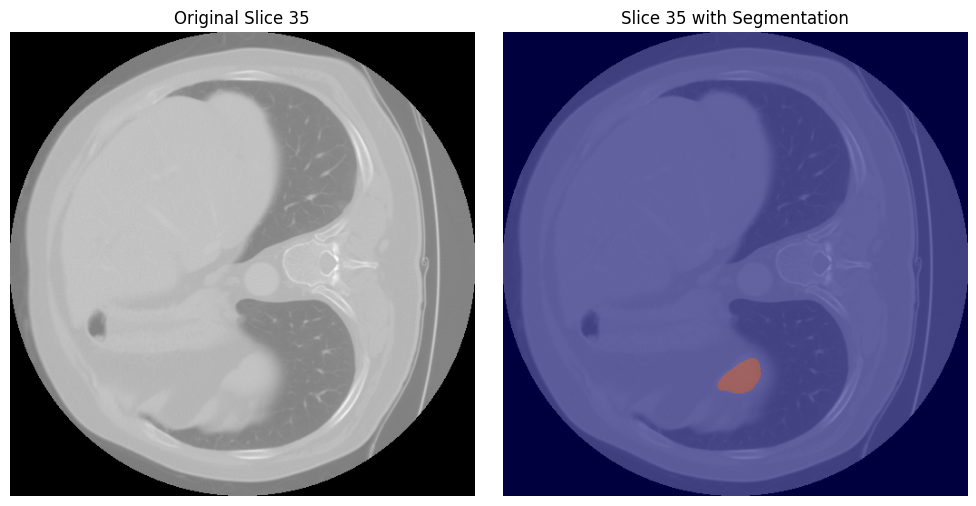

In [ ]:
image_nifti = nib.load(image_path)
seg_nifti = nib.load(seg_path)

image_data = image_nifti.get_fdata()
seg_data = seg_nifti.get_fdata()

print("Image shape:", image_data.shape)
print("Seg shape:", seg_data.shape)

# ✅ Choose one class (e.g., class 1, index 1)
seg_data_single = seg_data[:, :, :]  # Change index as needed

# 🔍 Loop through slices where segmentation mask has non-zero values
num_slices = image_data.shape[2]

for i in range(num_slices):
    if np.any(seg_data_single[:, :, i]):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(image_data[:, :, i], cmap='gray')
        axs[0].set_title(f'Original Slice {i}')
        axs[0].axis('off')

        axs[1].imshow(image_data[:, :, i], cmap='gray')
        axs[1].imshow(seg_data_single[:, :, i], cmap='jet', alpha=0.5)
        axs[1].set_title(f'Slice {i} with Segmentation')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()


## 📤 Converting NIfTI Segmentations to DICOM-SEG Using DCMQI

This script automates the conversion of predicted segmentation masks (in NIfTI format) to DICOM-SEG format using the `itkimage2segimage` tool from [DCMQI](https://github.com/QIICR/dcmqi). Each patient's segmentation is processed individually and saved to a common output directory.

In [ ]:
!chmod +x /content/drive/MyDrive/dcmqi-1.4.0-linux/dcmqi-1.4.0-linux/bin/itkimage2segimage

In [ ]:
for patient_id in os.listdir(segmentation_nifti_dir):
    nifti_path = os.path.join(segmentation_nifti_dir, patient_id, f"{patient_id}_seg.nii.gz")
    dicom_path = os.path.join(dicom_root, patient_id)
    output_seg_dcm = os.path.join(output_dicomseg_root, f"{patient_id}_seg.dcm")

    if not os.path.exists(nifti_path) or not os.path.exists(dicom_path):
        print(f"❌ Skipping {patient_id} (missing data)")
        continue

    command = [
        dcmqi_bin,
        "--inputImageList", nifti_path,
        "--inputDICOMDirectory", dicom_path,
        "--outputDICOM", output_seg_dcm,
        "--inputMetadata", metadata_json_path,
        "--useLabelIDAsSegmentNumber",
        "--skip", "1",
        "--referencesGeometryCheck", "0"
    ]

    print(f"🔄 Converting: {patient_id}")
    subprocess.run(command, check=True)
    print(f"✅ Saved: {output_seg_dcm}")


🔄 Converting: CRLM-CT-1005
✅ Saved: /content/out/dicomSeg/CRLM-CT-1005_seg.dcm
🔄 Converting: CRLM-CT-1003
✅ Saved: /content/out/dicomSeg/CRLM-CT-1003_seg.dcm
🔄 Converting: CRLM-CT-1006
✅ Saved: /content/out/dicomSeg/CRLM-CT-1006_seg.dcm
🔄 Converting: CRLM-CT-1002
✅ Saved: /content/out/dicomSeg/CRLM-CT-1002_seg.dcm
🔄 Converting: CRLM-CT-1004
✅ Saved: /content/out/dicomSeg/CRLM-CT-1004_seg.dcm
